In [2]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import os

from fastspeech import FastSpeech
from text import text_to_sequence
import hparams as hp
import utils
import audio as Audio

# Устройство (CPU или GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Функция для загрузки модели FastSpeech
def get_FastSpeech(checkpoint_path):
    model = nn.DataParallel(FastSpeech()).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model'])
    model.eval()
    return model

# Функция для синтеза речи и воспроизведения аудио
def synthesize_and_play(model, text, alpha=1.0):
    # Преобразование текста в последовательность
    sequence = np.array(text_to_sequence(text, hp.text_cleaners))
    sequence = np.stack([sequence])

    src_pos = np.array([i+1 for i in range(sequence.shape[1])])
    src_pos = np.stack([src_pos])

    # Преобразование в тензоры
    sequence = torch.from_numpy(sequence).long().to(device)
    src_pos = torch.from_numpy(src_pos).long().to(device)

    # Синтез мел-спектрограммы
    with torch.no_grad():
        mel_output, mel_postnet_output = model.module.forward(sequence, src_pos, alpha=alpha)
        mel_postnet_output = mel_postnet_output[0].cpu().transpose(0, 1)
    
    # Преобразование мел-спектрограммы в аудио с помощью Гриффина-Лима
    wav = Audio.tools.inv_mel_spec(mel_postnet_output, './results/test.wav')
    
    # Воспроизведение аудио
    #ipd.display(ipd.Audio(wav, rate = 16000))
    
    # Отображение мел-спектрограммы
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_postnet_output, aspect='auto', origin='lower')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


In [6]:
checkpoint_num = 40000  # Номер контрольной точки
checkpoint_path = os.path.join(hp.checkpoint_path, f'checkpoint_{checkpoint_num}.pth.tar')
model = get_FastSpeech(checkpoint_path)


/tmp/ipykernel_1471/3848531278.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model'])


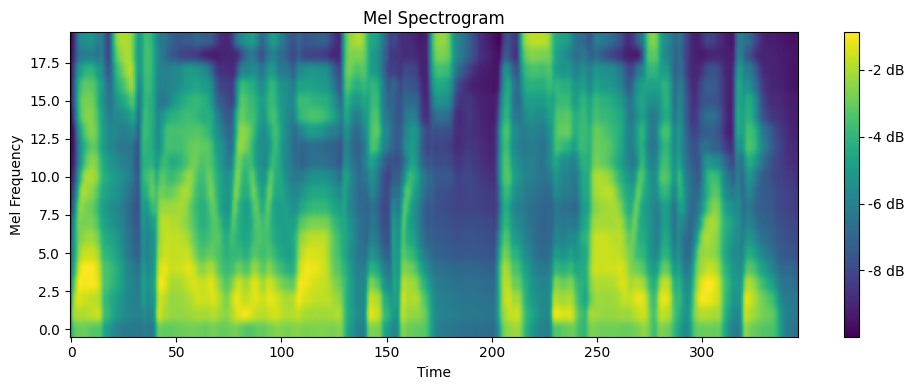

1.0821402710025723


In [7]:
import time
start = time.perf_counter()
text = "Lets try a really long sequence and see how is it working!"
synthesize_and_play(model, text, alpha=1)
dur = time.perf_counter() - start
print(dur)

In [8]:
ipd.display(ipd.Audio('./results/test.wav', rate = 16000))

In [1]:
import torch
import numpy as np
import soundfile as sf

def mel_to_audio_waveglow(mel_spectrogram_path, output_audio_path, sample_rate=22050):
    """
    Преобразует мел-спектрограмму в аудио с использованием предобученной модели WaveGlow.
    
    :param mel_spectrogram_path: Путь к .npy файлу с мел-спектрограммой.
    :param output_audio_path: Путь для сохранения выходного аудио файла.
    :param sample_rate: Частота дискретизации.
    """
    # Определение устройства (CPU/GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Используемое устройство: {device}")
    
    # Загрузка предобученной модели WaveGlow через Torch Hub
    print("Загрузка предобученной модели WaveGlow...")
    try:
        waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 
                                  'nvidia_waveglow', 
                                  model_math='fp32')
    except Exception as e:
        print(f"Ошибка при загрузке модели WaveGlow: {e}")
        return
    
    waveglow = waveglow.to(device)
    waveglow.eval()
    print("Модель WaveGlow загружена успешно.")
    
    # Загрузка мел-спектрограммы
    print(f"Загрузка мел-спектрограммы из {mel_spectrogram_path}...")
    try:
        mel = np.load(mel_spectrogram_path)
    except Exception as e:
        print(f"Ошибка при загрузке мел-спектрограммы: {e}")
        return
    
    # Проверка размерности мел-спектрограммы
    if mel.ndim != 2:
        print(f"Ошибка: Ожидалась 2-мерная мел-спектрограмма, получено {mel.ndim}-мерная.")
        return
    
    # Преобразование в формат torch.Tensor
    mel = torch.from_numpy(mel).float()
    
    # Добавление батч-дименсии и канала (1, n_mels, T)
    mel = mel.unsqueeze(0).to(device)
    
    # Генерация аудио
    print("Преобразование мел-спектрограммы в аудио...")
    with torch.no_grad():
        audio = waveglow.infer(mel).squeeze(0).cpu().numpy()
    
    # Нормализация аудио
    audio = audio / np.max(np.abs(audio))
    
    # Сохранение аудио
    print(f"Сохранение аудио в {output_audio_path}...")
    try:
        sf.write(output_audio_path, audio, sample_rate)
    except Exception as e:
        print(f"Ошибка при сохранении аудио файла: {e}")
        return
    
    print(f"Аудио успешно сохранено по пути: {output_audio_path}")

# Пример использования функции
if __name__ == "__main__":
    mel_path = "/workspace/TTSproject/fastspeech/FastSpeech/mels/ljspeech-mel-00001.npy"
    audio_output_path = "/workspace/TTSproject/fastspeech/FastSpeech/result/ljspeech-mel-00001.wav"
    mel_to_audio_waveglow(mel_path, audio_output_path)


Используемое устройство: cuda
Загрузка предобученной модели WaveGlow...


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be load

Модель WaveGlow загружена успешно.
Загрузка мел-спектрограммы из /workspace/TTSproject/fastspeech/FastSpeech/mels/ljspeech-mel-00001.npy...
Преобразование мел-спектрограммы в аудио...


RuntimeError: Given transposed=1, weight of size [80, 80, 1024], expected input[1, 832, 20] to have 80 channels, but got 832 channels instead

# строим графики выравниваний чтоб понять как их делать)))

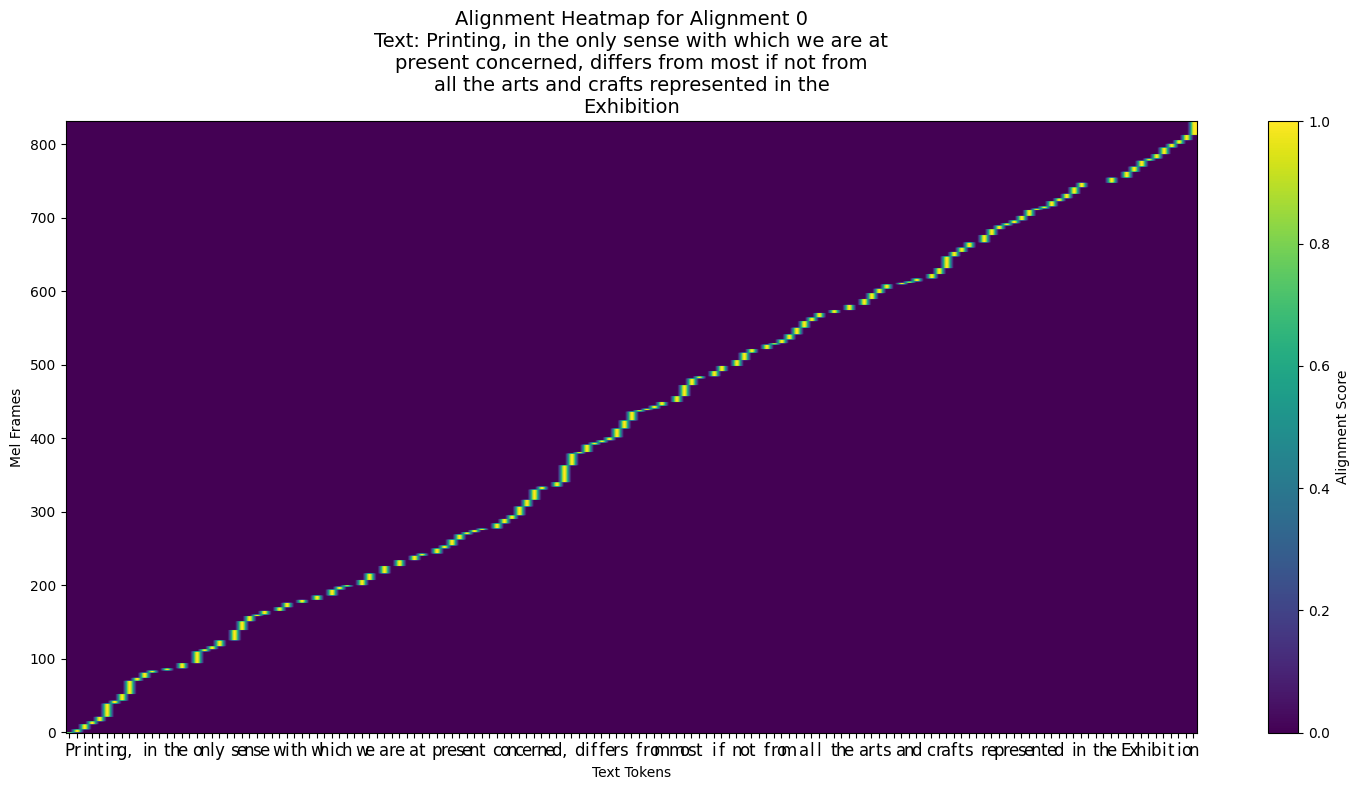

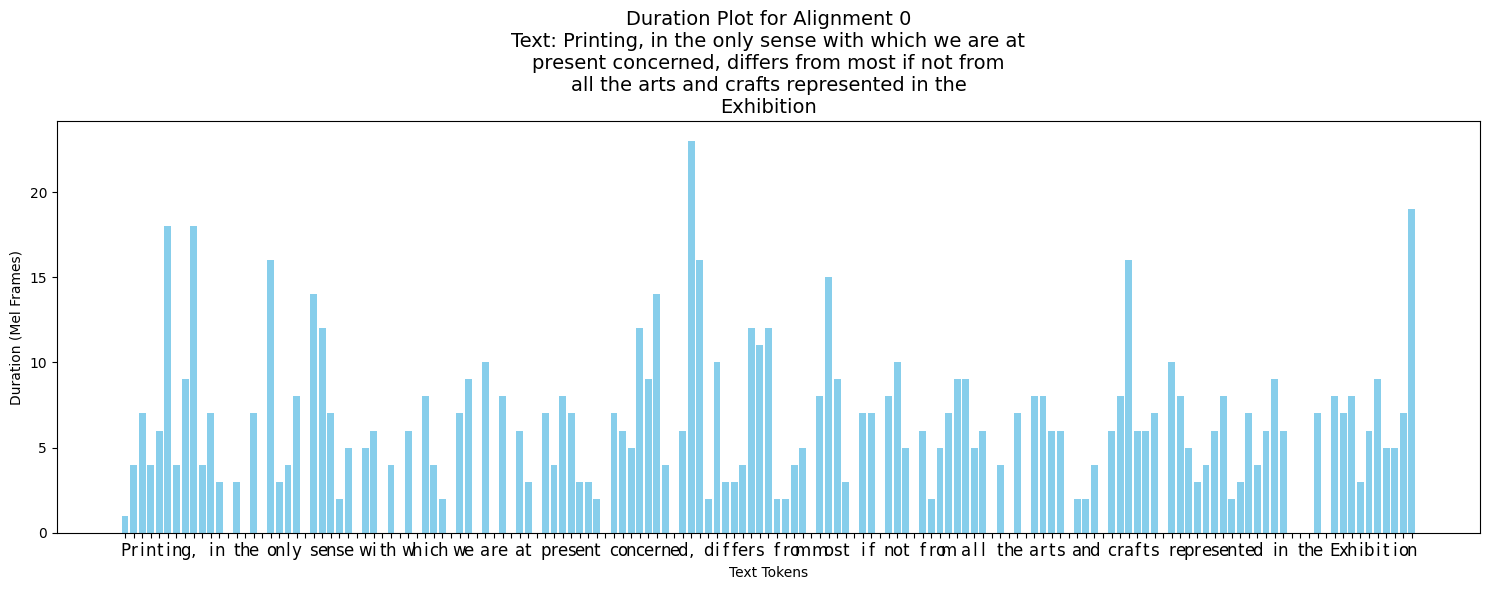

In [89]:
import os
import numpy as np
import matplotlib.pyplot as plt
import textwrap

def create_alignment_matrix(D):
    """
    Создаёт двумерную матрицу выравнивания из вектора длительностей.
    
    :param D: 1D numpy array. Вектор длительностей.
    :return: 2D numpy array. Матрица выравнивания.
    """
    total_mel = int(D.sum())
    alignment_matrix = np.zeros((len(D), total_mel))
    
    current_mel = 0
    for i, duration in enumerate(D):
        for _ in range(duration):
            if current_mel < total_mel:
                alignment_matrix[i, current_mel] = 1
                current_mel += 1
            else:
                break  # Предотвращает выход за границы матрицы
    
    return alignment_matrix

def plot_alignment_from_D(d_path, train_txt_path, index, title="Alignment Heatmap"):
    """
    Создаёт и визуализирует матрицу выравнивания на основе вектора длительностей и отображает соответствующий текст.
    Текстовые токены располагаются по горизонтали (оси X), а mel-фреймы — по вертикали (оси Y).
    
    :param d_path: Строка. Путь к .npy файлу с вектором длительностей.
    :param train_txt_path: Строка. Путь к файлу train.txt с текстовыми данными.
    :param index: Целое число. Индекс файла выравнивания и соответствующей строки в train.txt.
    :param title: Строка. Заголовок графика.
    """
    # Проверка существования файла длительностей
    if not os.path.isfile(d_path):
        raise FileNotFoundError(f"Файл не найден: {d_path}")
    
    # Проверка существования файла train.txt
    if not os.path.isfile(train_txt_path):
        raise FileNotFoundError(f"Файл train.txt не найден: {train_txt_path}")
    
    # Чтение соответствующей строки из train.txt
    with open(train_txt_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        if index >= len(lines):
            raise IndexError(f"Индекс {index} превышает количество строк в train.txt ({len(lines)})")
        text = lines[index].strip()
    
    # Загрузка вектора длительностей
    D = np.load(d_path)
    
    # Проверка размерности
    if D.ndim != 1:
        raise ValueError(f"Ожидался 1-мерный вектор длительностей, получено {D.ndim}-мерный.")
    
    # Создание матрицы выравнивания
    alignment = create_alignment_matrix(D)
    
    # Проверка размерности
    if alignment.ndim != 2:
        raise ValueError(f"Ожидалась 2-мерная матрица, получено {alignment.ndim}-мерная.")
    
    # Проверка соответствия длины mel-спектрограммы сумме длительностей
    mel_length = alignment.shape[1]
    if mel_length != int(D.sum()):
        print(f"Warning: Sum of durations {int(D.sum())} does not match mel length {mel_length}")
    
    # Подготовка меток для оси X (символы текста)
    tokens = list(text)  # Разбиваем текст на символы
    num_tokens = len(tokens)
    
    # Если количество строк в матрице выравнивания больше количества токенов, обрезаем
    if num_tokens < alignment.shape[0]:
        tokens = tokens + [''] * (alignment.shape[0] - num_tokens)
    elif num_tokens > alignment.shape[0]:
        tokens = tokens[:alignment.shape[0]]
    
    # Транспонируем матрицу выравнивания для расположения токенов по X
    alignment = alignment.T  # Теперь форма (mel_length, text_length)
    
    # Построение тепловой карты
    plt.figure(figsize=(15, 8))
    plt.imshow(alignment, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Alignment Score')
    plt.ylabel('Mel Frames')
    plt.xlabel('Text Tokens')
    
    # Настройка меток оси X (текстовые токены)
    plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, fontsize=12, rotation=0)
    
    # Добавление заголовка с текстом
    wrapped_text = "\n".join(textwrap.wrap(text, width=50))
    plt.title(f"{title}\nText: {wrapped_text}", fontsize=14)
    
    # Улучшение отображения графика
    plt.tight_layout()
    plt.show()
    
    # Закрытие фигуры
    plt.close()

def plot_duration(d_path, train_txt_path, index, title="Duration Plot"):
    """
    Загружает вектор длительностей и строит бар-чарт с соответствующим текстом.
    Текстовые токены подписаны под соответствующими делениями на оси X.
    
    :param d_path: Строка. Путь к .npy файлу с вектором длительностей.
    :param train_txt_path: Строка. Путь к файлу train.txt с текстовыми данными.
    :param index: Целое число. Индекс файла выравнивания и соответствующей строки в train.txt.
    :param title: Строка. Заголовок графика.
    """
    # Проверка существования файла длительностей
    if not os.path.isfile(d_path):
        raise FileNotFoundError(f"Файл не найден: {d_path}")
    
    # Проверка существования файла train.txt
    if not os.path.isfile(train_txt_path):
        raise FileNotFoundError(f"Файл train.txt не найден: {train_txt_path}")
    
    # Чтение соответствующей строки из train.txt
    with open(train_txt_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        if index >= len(lines):
            raise IndexError(f"Индекс {index} превышает количество строк в train.txt ({len(lines)})")
        text = lines[index].strip()
    
    # Загрузка вектора длительностей
    D = np.load(d_path)
    
    # Проверка размерности
    if D.ndim != 1:
        raise ValueError(f"Ожидался 1-мерный вектор длительностей, получено {D.ndim}-мерный.")
    
    # Подготовка меток для оси X (символы текста)
    tokens = list(text)  # Разбиваем текст на символы
    num_tokens = len(tokens)
    
    # Создание индексов для меток
    token_indices = np.arange(len(D))
    
    # Если количество токенов превышает количество длительностей, обрезаем
    if num_tokens > len(D):
        tokens = tokens[:len(D)]
    elif num_tokens < len(D):
        tokens = tokens + [''] * (len(D) - num_tokens)
    
    # Построение бар-чарта
    plt.figure(figsize=(15, 6))
    plt.bar(token_indices, D, color='skyblue')
    plt.xlabel('Text Tokens')
    plt.ylabel('Duration (Mel Frames)')
    
    # Настройка меток оси X (текстовые токены)
    plt.xticks(ticks=token_indices, labels=tokens, fontsize=12, rotation=0)
    
    # Добавление заголовка с текстом
    wrapped_text = "\n".join(textwrap.wrap(text, width=50))
    plt.title(f"{title}\nText: {wrapped_text}", fontsize=14)
    
    # Улучшение отображения графика
    plt.tight_layout()
    plt.show()
    
    # Закрытие фигуры
    plt.close()

# Пример использования функций
if __name__ == "__main__":
    # Путь к файлу длительностей
    D_file = "/workspace/TTSproject/fastspeech/FastSpeech/alignments/alignments/0.npy"
    
    # Путь к файлу train.txt
    train_txt = "/workspace/TTSproject/fastspeech/FastSpeech/data/train.txt"
    
    # Индекс файла выравнивания и строки в train.txt
    index = 0  # Для файла 0.npy
    
    # Вызов функции для построения и отображения матрицы выравнивания
    plot_alignment_from_D(D_file, train_txt, index, title="Alignment Heatmap for Alignment 0")
    
    # Вызов функции для построения и отображения графика длительностей
    plot_duration(D_file, train_txt, index, title="Duration Plot for Alignment 0")


In [66]:

!ps aux | grep train

root        1280  100  3.2 17935336 2085972 pts/1 Rsl+ 11:12  47:48 python train.py
root        1402  0.0  0.0   4780  3328 pts/2    Ss+  12:00   0:00 /bin/bash -c ps aux | grep train
root        1410  0.0  0.0   4020  2048 pts/2    S+   12:00   0:00 grep train


# для репо для гита

In [10]:
# Настройка Git пользователя
!git config --global user.email "anton.statnik@yandex.ru"
!git config --global user.name "Anton"


In [11]:
# Перейти в директорию проекта
%cd /workspace/TTSproject/


/workspace/TTSproject


In [16]:
# Проверка статуса Git-репозитория
!git status


On branch main
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)
	modified:   .ipynb_checkpoints/preparations-checkpoint.ipynb
	modified:   fastspeech (modified content, untracked content)
	modified:   preparations.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
